In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [2]:
df = pd.read_csv('/Users/an-chilu/Desktop/Temp 242A repo/Bank_Marketing_Split_dataset_with_allocations.csv')
df.head(5)

,ClientID,Age,Gender,MaritalStatus,EducationLevel,EmploymentStatus,JobTitle,Region,SalaryCategory,CustomerSegment,...,DaysSinceLastContact,PreviousYearDeposit,MarketingScore,ResponsePropensity,TermDepositSubscribed,US_Equity,International_Equity,Bonds,REIT,Cash
0,1,46,Male,Divorced,Secondary,Employed,Services,East,Mid,Mass,...,475,0,1.7179,0.21,0,0.24,0.18,0.12,0.12,0.34
1,2,39,Female,Married,Secondary,Self-employed,Blue-collar,Central,Low,Premium,...,-1,0,1.6803,0.46,1,0.08,0.06,0.24,0.04,0.58
2,3,48,Male,Married,Secondary,Self-employed,Services,South,Mid,Mass,...,318,0,1.0510,0.22,1,0.16,0.12,0.18,0.08,0.46
3,4,59,Female,Married,Secondary,Employed,Student,South,Low,Mass,...,819,0,1.5676,0.30,0,0.16,0.12,0.18,0.08,0.46
4,5,38,Male,Married,Tertiary,Employed,Retired,North,Low,Mass,...,362,0,1.2918,0.33,0,0.16,0.12,0.18,0.08,0.46


In [3]:
# first keep columns
# columns_keep = ['Age', 
# 'MaritalStatus',
# 'EducationLevel',
# 'AnnualIncome',
# 'NetWorth',
# 'AccountBalance',
# 'InvestmentPortfolioValue',
# 'SalaryCategory',
# 'RiskRating',
# 'CustomerSegment',
# 'HasMortgage',
# 'HasPersonalLoan', 'US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']
# df_specific_columns = df[columns_keep]

# second keep columns - by induction
# ['Age', 'Gender', 'MaritalStatus', 'EducationLevel', 'EmploymentStatus',
#        'Region', 'SalaryCategory', 'CustomerSegment', 'AnnualIncome',
#        'NetWorth', 'CreditScore', 'CreditLimit', 'RiskRating',
#        'AccountLengthYears', 'TenureWithBank', 'AccountBalance',
#        'NumBankProducts', 'HasMutualFunds', 'InvestmentPortfolioValue',
#        'NumOnlineTransactions', 'NumMobileAppLogins', 'ChannelPreference',
#        'WebsiteActivityScore', 'US_Equity', 'International_Equity', 'Bonds',
#        'REIT', 'Cash']

# I. Data Preprocessing 
Since the dataset is based on the Bank Marketing Dataset for Term Deposit Prediction, it contains a wide range of customer demographic and financial information that is also relevant for client portfolio allocation. Therefore, we first filter out non-relevant variables and retain only those features that are meaningful for modeling investment preferences, tailoring the dataset to the specific objectives of our robo-advisor framework.

In [4]:
df = df.drop(columns = ['ClientID', 'LastContactChannel',
'LastContactMonth',
'LastContactDay',
'LastContactDuration',
'NumContactsInCampaign',
'NumPrevCampaignContacts',
'PrevCampaignOutcome',
'CallResponseScore',
'DaysSinceLastContact',
'PreviousYearDeposit',
'MarketingScore',
'ResponsePropensity',
'TermDepositSubscribed', 'JobTitle', 'BranchVisitFrequency',
'TotalTransactions',
'AvgTransactionValue',
'HasLifeInsurance',
'HasPersonalLoan',
'HasMortgage',
'HasCreditCard'
])
df.dtypes

Age                           int64
Gender                       object
MaritalStatus                object
EducationLevel               object
EmploymentStatus             object
Region                       object
SalaryCategory               object
CustomerSegment              object
AnnualIncome                float64
NetWorth                    float64
CreditScore                   int64
CreditLimit                 float64
RiskRating                   object
AccountLengthYears            int64
TenureWithBank                int64
AccountBalance              float64
NumBankProducts               int64
HasMutualFunds               object
InvestmentPortfolioValue    float64
NumOnlineTransactions         int64
NumMobileAppLogins            int64
ChannelPreference            object
WebsiteActivityScore        float64
US_Equity                   float64
International_Equity        float64
Bonds                       float64
REIT                        float64
Cash                        

#### Examine the columns with 'Object' values.

In [5]:
for i in df.select_dtypes(include="object").columns:
    print(f'{i}:' , f'{df[i].unique()}')

Gender: ['Male' 'Female']
MaritalStatus: ['Divorced' 'Married' 'Single' 'Widowed']
EducationLevel: ['Secondary' 'Tertiary' 'Primary' 'Unknown']
EmploymentStatus: ['Employed' 'Self-employed' 'Student' 'Retired' 'Unemployed']
Region: ['East' 'Central' 'South' 'North' 'Metro' 'West']
SalaryCategory: ['Mid' 'Low' 'High' 'UpperMid']
CustomerSegment: ['Mass' 'Premium' 'Standard' 'Private']
RiskRating: ['High' 'Medium' 'Low']
HasMutualFunds: ['No' 'Yes']
ChannelPreference: ['Digital' 'Hybrid' 'Branch']


#### Some columns are considered ordinal instead of categorical variables, so we map each level with values then encode the rest.

In [6]:
ordinal_maps = {
    'EducationLevel':{'Unknown': 0, 'Primary': 1, 'Secondary': 2, 'Tertiary': 3},
    'SalaryCategory': {'Low': 1, 'Mid': 2, 'UpperMid': 3, 'High': 4},
    'CustomerSegment': {'Mass': 1, 'Standard': 2, 'Premium': 3, 'Private': 4},
    'RiskRating': {'Low': 1, 'Medium': 2, 'High': 3}
}
for col, mapping in ordinal_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

categorical_list = ['Gender', 'MaritalStatus', 'EmploymentStatus', 'Region', 'HasMutualFunds', 'ChannelPreference']

df_encoded = pd.get_dummies(
    df,
    columns=categorical_list,
    drop_first=True,
    dtype=int
)

In [7]:
df_encoded.head()

,Age,EducationLevel,SalaryCategory,CustomerSegment,AnnualIncome,NetWorth,CreditScore,CreditLimit,RiskRating,AccountLengthYears,...,EmploymentStatus_Student,EmploymentStatus_Unemployed,Region_East,Region_Metro,Region_North,Region_South,Region_West,HasMutualFunds_Yes,ChannelPreference_Digital,ChannelPreference_Hybrid
0,46,2,2,1,50548.83,31921.38,600,27580.55,3,5,...,0,0,1,0,0,0,0,0,1,0
1,39,2,1,3,28168.89,80356.77,712,24677.93,2,10,...,0,0,0,0,0,0,0,0,1,0
2,48,2,2,1,35797.77,36070.52,458,18168.59,3,5,...,0,0,0,0,0,1,0,0,1,0
3,59,2,1,1,10000.00,11767.30,645,14759.73,2,8,...,0,0,0,0,0,1,0,0,0,1
4,38,3,1,1,24344.60,8545.45,556,17268.96,3,12,...,0,0,0,0,1,0,0,0,1,0


# Train-Test Split
#### Training Set: 80% of data

#### Testing Set: 20% of data

In [8]:
X = df_encoded.drop(columns = ['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash'])
Y = df_encoded[['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# II. Model Prediction

## A. Linear Regression

### 1. Baseline Linear Regression

In [9]:
# standardize x_train 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# baseline linear regression
base_linear_model = LinearRegression()
base_linear_model.fit(x_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 2. Upgraded Linear Regression - Lasso, Ridge, ElasticNet

In [10]:
# Lasso 
lasso_linear_model = MultiOutputRegressor(Lasso(alpha=0.01))
lasso_linear_model.fit(x_train_scaled, y_train)

# Ridge
ridge_linear_model = Ridge(alpha=1.0)
ridge_linear_model.fit(x_train_scaled , y_train)

# ElasticNet
elasticnet_linear_model = MultiOutputRegressor(
    ElasticNet(alpha=0.01, l1_ratio=0.3)
)
elasticnet_linear_model.fit(x_train_scaled, y_train)

,estimator,ElasticNet(al... l1_ratio=0.3)
,n_jobs,None
,alpha,0.01
,l1_ratio,0.3
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False


### Performance Evaluation of Linear Models

In [11]:
# A function to do models' performance evaluation
def evaluate_models_overall(models, X, Y, prefix=""):
    rows = []
    for name, model in models.items():
        yhat = model.predict(X)
        rows.append({
            "Model": name,
            f"{prefix}R²": r2_score(Y, yhat, multioutput="uniform_average"),
            f"{prefix}RMSE": root_mean_squared_error(Y, yhat, multioutput="uniform_average")
        })
    return pd.DataFrame(rows)

In [12]:
# Training dataset evaluation on all linear models
models_linear = {
    "Linear": base_linear_model,
    "Lasso": lasso_linear_model,
    "Ridge": ridge_linear_model,
    "ElasticNet": elasticnet_linear_model
}
linear_model_train_performance_all = evaluate_models_overall(
    models_linear, x_train_scaled, y_train, prefix="Train "
)
linear_model_train_performance_all

,Model,Train R²,Train RMSE
0,Linear,0.924371,0.021924
1,Lasso,0.768124,0.034844
2,Ridge,0.924371,0.021924
3,ElasticNet,0.907865,0.023725


In [13]:
# Testing dataset evaluation on all linear models
x_test_scaled = scaler.transform(x_test)
linear_model_test_performance_all = evaluate_models_overall(
    models_linear, x_test_scaled, y_test, prefix="Test "
)
linear_model_test_performance_all

,Model,Test R²,Test RMSE
0,Linear,0.924820,0.021625
1,Lasso,0.770103,0.034319
2,Ridge,0.924821,0.021625
3,ElasticNet,0.909108,0.023306


### Feature Importance

In [14]:
# Linear Baseline Model feature importance 
linear_coef = base_linear_model.coef_
linear_importance = (
    pd.DataFrame(linear_coef, columns=x_train.columns)
    .abs()
    .mean(axis=0)
    .sort_values(ascending=False)
)

# Ridge Linear Model feature importance 
asset_names = ["US_Equity", "International_Equity", "Bonds", "REIT", "Cash"]
ridge_coef = ridge_linear_model.coef_          # shape: (5, n_features)
ridge_coef_df = pd.DataFrame(ridge_coef, index=asset_names, columns=x_train.columns)
ridge_feature_overall_importance = ridge_coef_df.abs().mean(axis=0).sort_values(ascending=False)

# feature importance dataframe - baseline linear, ridge linear
linear_feature_importance_df = pd.concat(
    [
        linear_importance.rename("Base Linear"),
        ridge_feature_overall_importance.rename("Ridge")
    ],
    axis=1
)

# Optional: sort by Ridge importance (more stable)
linear_feature_importance_df = linear_feature_importance_df.sort_values(
    by="Ridge", ascending=False
)

linear_feature_importance_df.head(15)

,Base Linear,Ridge
SalaryCategory,0.050350,0.050315
EmploymentStatus_Retired,0.041840,0.041832
EmploymentStatus_Student,0.035087,0.035081
EmploymentStatus_Unemployed,0.029261,0.029255
EmploymentStatus_Self-employed,0.023243,0.023237
AnnualIncome,0.003649,0.003677
InvestmentPortfolioValue,0.000571,0.000570
MaritalStatus_Single,0.000564,0.000564
MaritalStatus_Widowed,0.000560,0.000560
AccountBalance,0.000542,0.000543


## B. Gradient Boosting

## C. Random Forest

## D. XGBoost

# Visualization

In [15]:
df

,Age,Gender,MaritalStatus,EducationLevel,EmploymentStatus,Region,SalaryCategory,CustomerSegment,AnnualIncome,NetWorth,...,InvestmentPortfolioValue,NumOnlineTransactions,NumMobileAppLogins,ChannelPreference,WebsiteActivityScore,US_Equity,International_Equity,Bonds,REIT,Cash
0,46,Male,Divorced,2,Employed,East,2,1,50548.83,31921.38,...,40495.45,45,122,Digital,10.05,0.24,0.18,0.12,0.12,0.34
1,39,Female,Married,2,Self-employed,Central,1,3,28168.89,80356.77,...,18710.40,56,120,Digital,9.81,0.08,0.06,0.24,0.04,0.58
2,48,Male,Married,2,Self-employed,South,2,1,35797.77,36070.52,...,3073.86,67,54,Digital,13.45,0.16,0.12,0.18,0.08,0.46
3,59,Female,Married,2,Employed,South,1,1,10000.00,11767.30,...,7165.52,55,147,Hybrid,20.03,0.16,0.12,0.18,0.08,0.46
4,38,Male,Married,3,Employed,North,1,1,24344.60,8545.45,...,4536.47,43,130,Digital,15.89,0.16,0.12,0.18,0.08,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,56,Male,Single,2,Employed,West,2,2,33186.94,29091.33,...,13605.18,47,69,Branch,12.40,0.24,0.18,0.12,0.12,0.34
9996,18,Male,Married,2,Retired,South,1,2,16646.32,7332.09,...,5958.03,66,33,Digital,15.26,0.08,0.06,0.24,0.04,0.58
9997,32,Male,Single,3,Self-employed,West,2,1,31313.55,16451.52,...,26472.65,58,96,Hybrid,18.58,0.16,0.12,0.18,0.08,0.46
9998,46,Female,Married,3,Unemployed,North,1,1,16934.76,10085.57,...,14382.03,39,72,Hybrid,13.96,0.08,0.06,0.24,0.04,0.58


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Compute correlation matrix
corr_df = df.drop(columns = ['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash'])
corr = corr_df.corr(numeric_only=True)

corr_df_encoded = pd.get_dummies(
    corr_df,
    columns=categorical_list,
    drop_first=False,
    dtype=int
)

KeyboardInterrupt: 

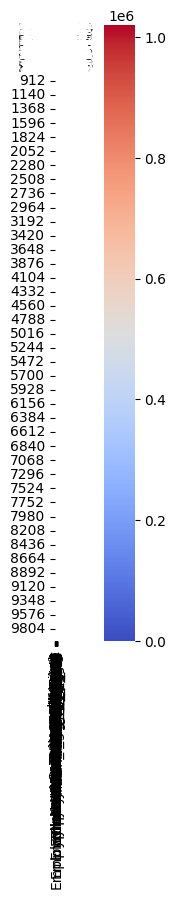

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_df_encoded,
    annot=True,           # show correlation values
    cmap='coolwarm',      # color scheme
    fmt='.2f',            # format values
    linewidths=0.5,
    square=True
)
plt.title("Correlation Heatmap of Features")
plt.show()